In [1]:
import gym
import gym.spaces
from gym.utils import seeding
from gym.envs.registration import EnvSpec
import enum
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import random

In [3]:
import time

In [4]:
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls

In [5]:
DEFAULT_BARS_COUNT = 50
DEFAULT_COMMISSION_PERC = 0.0025
DEFAULT_RISK_DISCOUNT = 0.001

In [6]:
class SAM_Env(Env):
    metadata = {'render.modes': ['human']}
    spec = EnvSpec('StocksEnv-v0') #not quite sure what this does, but 
    #i might change the name
    
    def __init__(self, msft_prices, dis_prices, jnj_prices, 
                 msft_signals, dis_signals, jnj_signals, libor, bars_count = DEFAULT_BARS_COUNT,
                commission_perc = DEFAULT_COMMISSION_PERC, risk_discount = DEFAULT_RISK_DISCOUNT, 
                 random_ofs_on_reset=True):
    
        self._msft_prices = msft_prices
        self._dis_prices = dis_prices
        self._jnj_prices = jnj_prices
        
        self._msft_signals = msft_signals
        self._dis_signals = dis_signals
        self._jnj_signals = jnj_signals
        
        self._libor = libor
    
        self.bars_count = bars_count
        self.commission_perc = commission_perc
        self.risk_discount = risk_discount
        self.random_ofs_on_reset = random_ofs_on_reset
    
        self._state = State(msft_prices, dis_prices, jnj_prices, libor, 
                            msft_signals, dis_signals, jnj_signals, bars_count, 
                            commission_perc, 
                            risk_discount, random_ofs_on_reset)
    
    def step(self, action, risk_discount):
        reward, done, return_ = self._state.step(action, risk_discount)
        
        msft_prices = self._msft_prices
        dis_prices = self._dis_prices
        jnj_prices = self._jnj_prices
        
        msft_signals = self._msft_signals
        dis_signals = self._dis_signals
        jnj_signals = self._jnj_signals
        
        libor = self._libor
        
        obs = self._state.encode(msft_prices, dis_prices, jnj_prices, msft_signals, 
                                  dis_signals, jnj_signals, libor)
        info = {
            'offset': self._state._offset
            #maybe add more
        }
        return obs, reward, done, info, return_
    
    def reset(self):
        msft_prices = self._msft_prices
        dis_prices = self._dis_prices
        jnj_prices = self._jnj_prices
        
        msft_signals = self._msft_signals
        dis_signals = self._dis_signals
        jnj_signals = self._jnj_signals
        
        libor = self._libor
        
        bars = self._state.bars_count
        if self.random_ofs_on_reset:
            offset = np.random.choice(
                msft_prices.close.shape[0]-bars*10) + bars
        else:
            offset = bars
        self._state.reset(msft_prices, dis_prices, jnj_prices, self._libor, offset)
        return self._state.encode(msft_prices, dis_prices, jnj_prices, msft_signals, 
                                  dis_signals, jnj_signals, libor)

In [7]:
class State:
    def __init__(self, msft_prices, dis_prices, jnj_prices, msft_signals, dis_signals, jnj_signals,
                 libor, bars_count, commission_perc, risk_discount, random_ofs_on_reset):
        assert isinstance(bars_count, int)
        assert bars_count > 0
        assert isinstance(commission_perc, float)
        assert commission_perc >= 0.0
        self.bars_count = bars_count
        self.commission_perc = commission_perc
        
        self._msft_signals = msft_signals
        self._dis_signals = dis_signals
        self._jnj_signals = jnj_signals
        self._libor = libor
        
    def reset(self, msft_prices, dis_prices, jnj_prices, libor, offset):
        assert isinstance(msft_prices, pd.DataFrame)
        assert isinstance(dis_prices, pd.DataFrame)
        assert isinstance(jnj_prices, pd.DataFrame)
        assert isinstance(libor, pd.DataFrame)
        assert offset >= self.bars_count-1
        self.weights = np.array([1, 0, 0, 0])
        self._msft_prices = msft_prices
        self._dis_prices = dis_prices
        self._jnj_prices = jnj_prices

        self._offset = offset
        
    @property
    def shape(self):
        return (7, 4, self.bars_count)
       
    def encode(self, msft_prices, dis_prices, jnj_prices, 
               msft_signals, dis_signals, jnj_signals, libor):
        
        self._msft_prices = msft_prices
        self._dis_prices = dis_prices
        self._jnj_prices = jnj_prices
        
        self._msft_signals = msft_signals
        self._dis_signals = dis_signals
        self._jnj_signals = jnj_signals
        
        self._libor = libor
        
        assert isinstance(self._libor, pd.DataFrame)
        
        res = np.zeros(shape=(7,4,50), dtype=np.float32)
        start = self._offset-(self.bars_count-1)
        stop = self._offset+1
        
        res[0][0] = np.zeros(self.bars_count) + 1
        res[0][1] = msft_prices.close[start:stop]
        res[0][2] = dis_prices.close[start:stop]
        res[0][3] = jnj_prices.close[start:stop]
        
        res[1][0] = np.zeros(self.bars_count) + 1
        res[1][1] = msft_prices.high[start:stop]
        res[1][2] = dis_prices.high[start:stop]
        res[1][3] = jnj_prices.high[start:stop]
        
        res[2][0] = np.zeros(self.bars_count) + 1
        res[2][1] = msft_prices.low[start:stop]
        res[2][2] = dis_prices.low[start:stop]
        res[2][3] = jnj_prices.low[start:stop]
        
        res[3][0] = np.zeros(self.bars_count) + 1
        res[3][1] = msft_prices.open[start:stop]
        res[3][2] = dis_prices.open[start:stop]
        res[3][3] = jnj_prices.open[start:stop]
        
        res[4][0] = np.zeros(self.bars_count) + 1
        res[4][1] = msft_prices.volume[start:stop]
        res[4][2] = dis_prices.volume[start:stop]
        res[4][3] = jnj_prices.volume[start:stop]
        
        res[5][0] = np.zeros(self.bars_count)
        res[5][1] = msft_signals[start:stop]
        res[5][2] = dis_signals[start:stop]
        res[5][3] = jnj_signals[start:stop]
        
        res[6][0] = libor.three_month[start:stop] 
        res[6][1] = libor.three_month[start:stop] 
        res[6][2] = libor.three_month[start:stop] 
        res[6][3] = libor.three_month[start:stop] 
        return res
    
    def _cur_close_changes(self):
        msft_change = self._msft_prices.close[self._offset+1]/self._msft_prices.close[self._offset]
        dis_change = self._dis_prices.close[self._offset+1]/self._dis_prices.close[self._offset]
        jnj_change = self._jnj_prices.close[self._offset+1]/self._jnj_prices.close[self._offset]
        
        return np.array([1, msft_change, dis_change, jnj_change])
    
    def _reward_function(self, action, changes, weights, risk_discount=0.001):
        performance = np.dot(changes, action)
        transaction_cost = self.commission_perc * np.sum([abs(action[i] - weights[i]) for i in range(4)])
        start = self._offset-(self.bars_count-1)
        stop = self._offset+1
        stock_averages = [np.average(self._msft_prices.close[start:stop]),
                         np.average(self._dis_prices.close[start:stop]),
                         np.average(self._jnj_prices.close[start:stop])]
        big_sum = 0
        for t in range(start, stop):
            lil_sum = 0
            for i in range(3):
                if i == 0:
                    lil_sum += (self._msft_prices.close[t] - stock_averages[0]) ** 2
                elif i == 1:
                    lil_sum += (self._dis_prices.close[t] - stock_averages[1]) ** 2
                elif i == 2:
                    lil_sum += (self._jnj_prices.close[t] - stock_averages[2]) ** 2
            big_sum += lil_sum
            
        volatility = risk_discount * (big_sum/self.bars_count)
        return_ = performance - transaction_cost
        return np.log(performance - transaction_cost - volatility), return_
            
    
    def step(self, action, risk_discount):
        close_changes = self._cur_close_changes()
        action = np.reshape(action, (4,))
        done = False
        
        self._offset += 1
        
        if self._offset >= self._msft_prices.close.shape[0] - 1:
            done = True
            
        self.weights = (close_changes * action) / (np.dot(close_changes, action))
        reward, day_return = self._reward_function(action, close_changes, self.weights, risk_discount)
        
        return reward, done, day_return

In [8]:
with pd.HDFStore('fixed_eam_actions.h5') as store:
    msft_train_signals = store['eam/msft/real_reward_best500/train/actions']
    msft_valid_signals = store['eam/msft/real_reward_best500/valid/actions']
    msft_test_signals = store['eam/msft/real_reward_best500/test/actions']
    dis_train_signals = store['eam/dis/real_reward_best500/train/actions']
    dis_valid_signals = store['eam/dis/real_reward_best500/valid/actions']
    dis_test_signals = store['eam/dis/real_reward_best500/test/actions']
    jnj_train_signals = store['eam/jnj/real_reward_best216/train/actions']
    jnj_valid_signals = store['eam/jnj/real_reward_best500/valid/actions']
    jnj_test_signals = store['eam/jnj/real_reward_best500/test/actions']

In [9]:
with pd.HDFStore('former_SOTA_sam_data.h5') as store:
    msft_train = store['dow/stock_fund/SAM/train/normalized/msft']
    msft_valid = store['dow/stock_fund/SAM/valid/normalized/msft']
    msft_test = store['dow/stock_fund/SAM/test/normalized/msft']
    dis_train = store['dow/stock_fund/SAM/train/normalized/dis']
    dis_valid = store['dow/stock_fund/SAM/valid/normalized/dis']
    dis_test = store['dow/stock_fund/SAM/test/normalized/dis']
    jnj_train = store['dow/stock_fund/SAM/train/normalized/jnj']
    jnj_valid = store['dow/stock_fund/SAM/valid/normalized/jnj']
    jnj_test = store['dow/stock_fund/SAM/test/normalized/jnj']

In [10]:
with pd.HDFStore('research.h5') as store:
    libor_train = store['libor/training_section/nochange/low_margin_interest']
    libor_valid = store['libor/validation_section/nochange/low_margin_interest']
    libor_test = store['libor/testing_section/nochange/low_margin_interest']

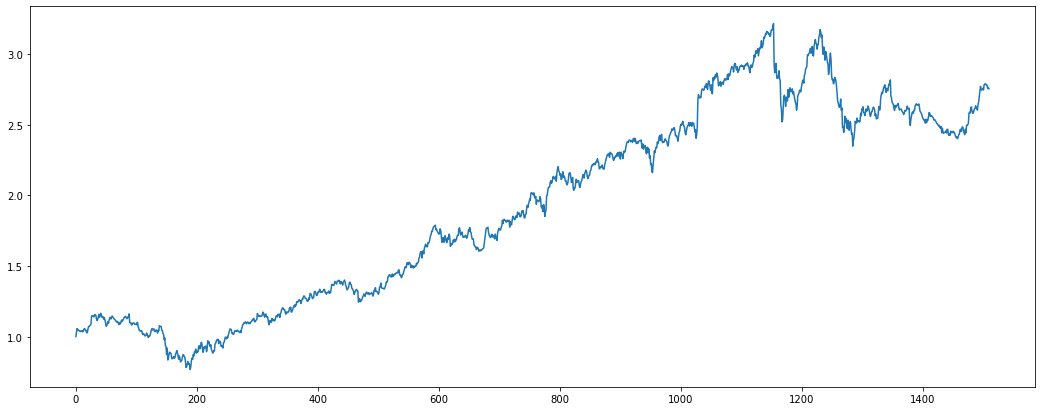

In [11]:
plt.figure(figsize=(18,7))
#plt.plot(msft_train.close)
plt.plot(dis_train.close)
#plt.plot(jnj_train.close)
plt.show()

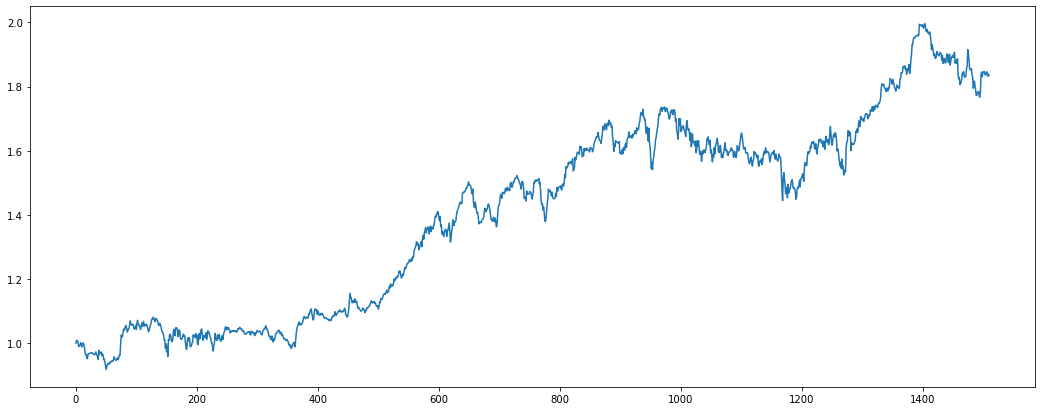

In [12]:
plt.figure(figsize=(18,7))
#plt.plot(msft_train.close)
#plt.plot(dis_train.close)
plt.plot(jnj_train.close)
plt.show()

In [19]:
env = SAM_Env(msft_train, dis_train, jnj_train, 
              msft_train_signals, dis_train_signals, jnj_train_signals, libor_train)
valid_env = SAM_Env(msft_valid, dis_valid, jnj_valid, 
              msft_valid_signals, dis_valid_signals, jnj_valid_signals, libor_valid, random_ofs_on_reset=False)
test_env = SAM_Env(msft_test, dis_test, jnj_test, 
              msft_test_signals, dis_test_signals, jnj_test_signals, libor_test, random_ofs_on_reset=False)

In [14]:
input_shape = (7, 4, 50)

In [15]:
K = keras.backend 
actor = keras.models.Sequential()
actor.add(keras.layers.Conv2D(3, (1,3), strides=1, data_format= 'channels_first', input_shape=input_shape, padding='valid',
                             activation='relu'))
actor.add(keras.layers.BatchNormalization())
actor.add(keras.layers.Conv2D(6, (1,12), strides=1, data_format= 'channels_first', padding='valid', activation='relu'))
actor.add(keras.layers.BatchNormalization())
actor.add(keras.layers.Conv2D(21, (1,37), strides=1, data_format= 'channels_first', padding='valid', activation='relu'))
actor.add(keras.layers.BatchNormalization())
actor.add(keras.layers.Conv2D(1, 1, strides=1, data_format= 'channels_first', activation='relu'))
actor.add(keras.layers.Flatten())
actor.add(keras.layers.Activation('relu'))
#actor.add(keras.layers.Dense(128, activation='relu')) #not sure this should be here
#actor.add(keras.layers.Dense(4, activation='relu'))

In [17]:
K = keras.backend 
critic = keras.models.Sequential()
critic.add(keras.layers.Conv2D(3, (1,3), strides=1, data_format='channels_first', input_shape=input_shape, padding='valid',
                             activation='relu'))
critic.add(keras.layers.BatchNormalization())
critic.add(keras.layers.Conv2D(6, (1,12), strides=1, data_format= 'channels_first', padding='valid', activation='relu'))
critic.add(keras.layers.BatchNormalization())
critic.add(keras.layers.Conv2D(21, (1,37), strides=1, data_format= 'channels_first', padding='valid', activation='relu'))
critic.add(keras.layers.BatchNormalization())
critic.add(keras.layers.Conv2D(1, 1, strides=1, data_format= 'channels_first', activation='relu'))
critic.add(keras.layers.Flatten())
#critic.add(keras.layers.Dense(128, activation='relu')) #not sure this should be here
critic.add(keras.layers.Dense(1, activation='relu'))

In [20]:
actor.load_weights('SAM_EIIE_actor_625episodes.h5')
critic.load_weights('SAM_EIIE_critic_625episodes.h5')

In [17]:
actor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 4, 48)          66        
                                                                 
 batch_normalization (BatchN  (None, 3, 4, 48)         192       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 4, 37)          222       
                                                                 
 batch_normalization_1 (Batc  (None, 6, 4, 37)         148       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 4, 1)          4683      
                                                                 
 batch_normalization_2 (Batc  (None, 21, 4, 1)         4

In [15]:
#K = keras.backend
#input_states = keras.layers.Input(shape=input_shape)
#conv1 = keras.layers.Conv2D(3, (1,3), strides=1, input_shape=input_shape, padding='same', 
#                            activation='relu')(input_states)
#conv2 = keras.layers.BatchNormalization()(conv1)
#conv3 = keras.layers.Conv2D(6, (1,12), strides=1, padding='same', activation='relu')(conv2)
#conv4 = keras.layers.BatchNormalization()(conv3)
#conv5 = keras.layers.Conv2D(21, (1,37), strides=1, padding='same', activation='relu')(conv4)
#conv6 = keras.layers.BatchNormalization()(conv5)
#conv7 = keras.layers.Conv2D(1, 1, strides=1, activation='relu')(conv6)
#flat = keras.layers.Flatten()(conv7)
#den1 = keras.layers.Dense(128, activation='relu')(flat)
#den2 = keras.layers.Dense(4, activation='relu')
#bactor = keras.models.Model(inputs=[input_states], outputs=[den2])

In [ ]:
#K = keras.backend
#input_states = keras.layers.Input(shape=input_shape)
#conv1 = keras.layers.Conv1D(3, 3, strides=1, input_shape=input_shape, padding='same', 
#                            activation='relu')(input_states)
#conv2 = keras.layers.BatchNormalization()(conv1)
#conv3 = keras.layers.Conv1D(6, 12, strides=1, padding='same', activation='relu')(conv2)
#conv4 = keras.layers.BatchNormalization()(conv3)
#conv5 = keras.layers.Conv1D(21, 37, strides=1, padding='same', activation='relu')(conv4)
#conv6 = keras.layers.BatchNormalization()(conv5)
#conv7 = keras.layers.Conv1D(1, 1, strides=1, activation='relu')(conv6)
#flat = keras.layers.Flatten()(conv7)
#dense = keras.layers.Dense(1)(flat)
#critic = keras.models.Model(inputs=[input_states], outputs=[dense])

In [184]:
#class critic(tf.keras.Model):
#    def __init__(self):
#        super().__init__()
#        self.in_ = tf.keras.layers.Input(shape=input_shape)
#        self.c1 = tf.keras.layers.Conv2D(3, (1,3), strides=1, input_shape=input_shape, padding='same', 
#                            activation='relu')
#        self.b1 = tf.keras.layers.BatchNormalization()
#        self.c2 = tf.keras.layers.Conv2D(6, (1,12), strides=1, padding='same', activation='relu')
#        self.b2 = tf.keras.layers.BatchNormalization()
#        self.c3 = tf.keras.layers.Conv2D(21, (1,37), strides=1, padding='same', activation='relu')
#        self.b3 = tf.keras.layers.BatchNormalization()
#        self.c4 = tf.keras.layers.Conv2D(1, 1, strides=1, activation='relu')
#        self.flat = tf.keras.layers.Flatten()
#        self.d1 = tf.keras.layers.Dense(128)
#        self.d2 = tf.keras.layers.Dense(1, activation='relu')
#        
#    def call(self, input_data):
#        q = self.in_(input_data)
#        w = self.c1(q)
#        e = self.b1(w)
#        r = self.c2(e)
#        t = self.b2(r)
#        y = self.c3(t)
#        u = self.b3(y)
#        i = self.c4(u)
#        o = self.flat(i)
#        p = self.d1(o)
#        a = self.d2(p)
#        return a
#        
#class actor(tf.keras.Model):
#    def __init__(self):
#        super().__init__()
#        self.in_ = tf.keras.layers.Input(shape=input_shape)
#        self.c1 = tf.keras.layers.Conv2D(3, (1,3), strides=1, input_shape=input_shape, padding='same', 
#                            activation='relu')
#        self.b1 = tf.keras.layers.BatchNormalization()
#        self.c2 = tf.keras.layers.Conv2D(6, (1,12), strides=1, padding='same', activation='relu')
#        self.b2 = tf.keras.layers.BatchNormalization()
#        self.c3 = tf.keras.layers.Conv2D(21, (1,37), strides=1, padding='same', activation='relu')
#        self.b3 = tf.keras.layers.BatchNormalization()
#        self.c4 = tf.keras.layers.Conv2D(1, 1, strides=1, activation='relu')
#        self.flat = tf.keras.layers.Flatten()
#        self.d1 = tf.keras.layers.Dense(4)
#        
#    def call(self, input_data):
#        q = self.in_(input_data)
#        w = self.c1(q)
#        e = self.b1(w)
#        r = self.c2(e)
#        t = self.b2(r)
#        y = self.c3(t)
#        u = self.b3(y)
#        i = self.c4(u)
#        o = self.flat(i)
#        p = self.d1(o)
#
#        return p

In [21]:
gamma = 0.99
clip_param = 0.2

In [22]:
def act(state):
    means = actor(state[np.newaxis])
    bill = keras.activations.get('softmax')
    return bill(means).numpy()

In [23]:
def actor_loss(probs, adv, old_probs):
    probability = probs
    entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probability+1e-14,tf.math.log(probability+1e-14))))
    #print(probability)
    #print(entropy)
    sur1 = []
    sur2 = []
        
    for pb, t, op in zip(probability, adv, old_probs):
        t = tf.constant(t)
        op = tf.constant(op)
        #print(t)
        ratio = tf.reduce_mean(tf.math.exp(tf.math.log(pb + 0.1) - tf.math.log(op + 0.1)))
        #print(ratio)
        s1 = tf.math.multiply(ratio, t)
        #print(s1)
        s2 = tf.math.multiply(tf.clip_by_value(ratio, 1.0 - clip_param, 1.0+clip_param), t)
        #print(s2)
        sur1.append(s1)
        sur2.append(s2)
            
    sr1 = tf.stack(sur1)
    sr2 = tf.stack(sur2)
        
    #is the 0.001 a hyperparameter?
    loss = tf.math.negative(tf.reduce_mean(tf.math.minimum(sr1, sr2)) + 0.001*entropy) #i changed it to minus entropy
    #loss = tf.reduce_mean(tf.math.minimum(sr1, sr2)) + 0.001*entropy
    #print(loss)
    return loss

In [25]:
def batch_maker(batch_size=50):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, adv, probs, rewards = [np.array([experience[field_index] for experience in batch])
                                  for field_index in range(4)]
    
    #batch_states = [states[index] for index in indices]
    #batch_adv = [adv[index] for index in indices]
    #batch_probs = [probs[index] for index in indices]
    #batch_reward_lst = [reward_list[index] for index in indices]
    
    return states, adv, probs, rewards

In [26]:
def learn(batch_size):
    
    #discount_rewards = tf.reshape(discount_rewards, (len(discount_rewards),))
    #adv = tf.reshape(adv, (len(adv),))
    #old_p = old_probs
    #old_p = tf.reshape(old_p, (len(old_p),4))
    
    batch_states, batch_adv, batch_old_p, batch_discount_rewards = batch_maker(batch_size)
    
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        p = actor(batch_states) #what the frcikle frack
        #print(p)
        v = critic(batch_states)
        v = tf.reshape(v, (len(v),))
        #print(v)
        td = tf.math.subtract(batch_discount_rewards, v)
        c_loss = 0.5 * kls.mean_squared_error(batch_discount_rewards, v)
        a_loss = actor_loss(p, batch_adv, batch_old_p)
            
    grads1 = tape1.gradient(a_loss, actor.trainable_variables)
    grads2 = tape2.gradient(c_loss, critic.trainable_variables)
    a_optimizer.apply_gradients(zip(grads1, actor.trainable_variables))
    c_optimizer.apply_gradients(zip(grads2, critic.trainable_variables))
    return a_loss, c_loss

In [27]:
def loss_calculator(states, adv, old_p, discount_rewards):
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        p = actor(np.array(states)) #what the frcikle frack
        #print(p)
        v = critic(np.array(states))
        v = tf.reshape(v, (len(v),))
        #print(v)
        td = tf.math.subtract(discount_rewards, v)
        c_loss = 0.5 * kls.mean_squared_error(discount_rewards, v)
        a_loss = actor_loss(p, adv, old_p)
    
    return a_loss, c_loss

In [28]:
def validation_run(env):
    done = False
    state = env.reset()
    cumprod_return = 1
    rewards = []
    states = []
    probs = []
    dones = []
    values = []
    num_steps = 0
    
    while not done:
        action = act(state)[0]
        value = critic(np.array([state])).numpy()
        next_state, reward, done, info, day_return = env.step(action, DEFAULT_RISK_DISCOUNT)
        dones.append(1-done)
        cumprod_return *= day_return
        rewards.append(reward)
        states.append(state)
        prob = actor(np.array([state])).numpy()
        probs.append(prob[0])
        values.append(value[0][0])
        state = next_state
        num_steps += 1
        
    value = critic(np.array([state])).numpy()
    values.append(value[0][0])
    np.reshape(probs, (len(probs),4))
    probs = np.stack(probs, axis=0)
    
    cumsum = np.sum(rewards)
    arr = (cumprod_return ** (1/(num_steps/252)))
    geomean = (cumprod_return ** (1/num_steps))
    mean = np.mean(rewards)
    
    states, returns, adv = preprocess(states, rewards, dones, values, 0.99725) #change the gamma value
    
    aloss, closs = loss_calculator(states, adv, probs, returns)
        
    return num_steps, cumprod_return, cumsum, arr, geomean, mean, float(aloss), float(closs)

In [29]:
def preprocess(states, rewards, done, values, gamma):
    g = 0
    lmbda = 0.95
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
        g = delta + gamma * lmbda * dones[i] * g
        returns.append(g + values[i])
        
    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    adv = (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    returns = np.array(returns, dtype=np.float32)
    return states, returns, adv 

In [30]:
def exp_lr(episode, start_lr, end_lr, episodes):
    num = start_lr/end_lr
    num2 = np.log(num) / episodes
    return (start_lr * np.exp((-episode)*num2))

In [31]:
def one_cycle(x, max_length, start, max_, end):
    midway = 0.4*max_length
    almost = 0.8*max_length
    if x <= midway:
        lr = start + ((max_-start)/midway)*x
    elif (x > midway) & (x <= almost):
        lr = 2*max_ - start - ((max_-start)/midway)*x
    elif (x > almost) & (x <= max_length):
        lr = x*((end-start)/(midway*0.5)) + 3.96*start + start
    
    return lr

In [28]:
with pd.HDFStore('sam_training.h5') as store:
    replay_buffer_series = store['SAM/EIIE/500episodes/neg_loss/replay_buffer']

In [33]:
replay_buffer = []
#replay_buffer = replay_buffer_series.tolist()

In [34]:
tf.random.set_seed(42)
episodes = 625 #can play around with this number later
reward_list = []
raw_return = []
arr_list = []
best_reward = -np.inf
avg_rewards = []
geomean_return = []
all_aloss = []
all_closs = []
eps_aloss = []
eps_valoss = []
eps_closs = []
eps_vcloss = []
durations = []
varr_list = []

In [31]:
for episode in range(500, episodes):
    
    #c_optimizer = keras.optimizers.Adam(learning_rate=exp_lr(episode, 3.16227766e-4, 1e-7, 625))
    #a_optimizer = keras.optimizers.Adam(learning_rate=exp_lr(episode, 3.16227766e-4, 1e-7, 625))
    #c_optimizer = keras.optimizers.Adam(learning_rate=exp_lr(episode, 1e-3, 1e-5, 625))
    #a_optimizer = keras.optimizers.Adam(learning_rate=exp_lr(episode, 1e-3, 1e-5, 625))
    c_optimizer = keras.optimizers.Adam(learning_rate=one_cycle(episode, 625, 5e-7, 5e-5, 5e-9))
    a_optimizer = keras.optimizers.Adam(learning_rate=one_cycle(episode, 625, 5e-6, 5e-4, 5e-8))
    
    start = time.time()
    done = False
    state = env.reset()
    cumprod_return = 1
    rewards = []
    states = []
    actions = []
    probs = []
    dones = []
    values = []
    ep_aloss = []
    ep_closs = []
    num_steps = 0
    print('-------------------------------------------------------------')
    
    while not done:
        action = act(state)[0]
        actions.append(action)
        value = critic(np.array([state])).numpy()
        next_state, reward, done, info, day_return = env.step(action, DEFAULT_RISK_DISCOUNT)
        dones.append(1-done)
        cumprod_return *= day_return
        rewards.append(reward)
        states.append(state)
        prob = actor(np.array([state])).numpy()
        probs.append(prob[0])
        values.append(value[0][0])
        state = next_state
        num_steps += 1
        
    value = critic(np.array([state])).numpy()
    values.append(value[0][0])
    np.reshape(probs, (len(probs),4))
    probs = np.stack(probs, axis=0)
    
    cumsum = np.sum(rewards)
    reward_list.append(cumsum)
    raw_return.append(cumprod_return)
    arr = (cumprod_return ** (1/(num_steps/252)))
    geomean = (cumprod_return ** (1/num_steps))
    arr_list.append(arr)
    mean = np.mean(rewards)
    avg_rewards.append(mean)
    geomean_return.append(geomean) 
    
    states, returns, adv = preprocess(states, rewards, dones, values, 0.99725) #change the gamma value
    
    for i in range(len(states)):
        datapoint = (states[i], adv[i], probs[i], returns[i])
        replay_buffer.append(datapoint)
        
    if len(replay_buffer) > 2e5:
        for i in range(1660):
            replay_buffer.pop(0)
    
    for i in range(64): #how many learning iterations do I want?
        aloss, closs = learn(50)
        all_aloss.append(aloss)
        all_closs.append(closs)
        ep_aloss.append(aloss)
        ep_closs.append(closs)
        
    aloss = round(np.mean(ep_aloss), 6)
    eps_aloss.append(aloss)
    closs = round(np.mean(ep_closs), 6)
    eps_closs.append(closs)
    
    vnum_steps, vcumprod, vcumsum, varr, vgeomean, vmean, valoss, vcloss = validation_run(valid_env)
    eps_valoss.append(valoss)
    eps_vcloss.append(vcloss)
    varr_list.append(varr)
    
    if varr >= best_reward:
        best_actor_weights = actor.get_weights()
        best_critic_weights = critic.get_weights()
        best_reward = varr
        
    stop = time.time()
    duration = stop-start
    durations.append(duration)
    print('Training Metrics:')
    print('Episode: {}, Steps: {}, Raw_Reward: {}, Avg_Reward: {}'.format(episode, num_steps, round(cumsum, 4), round(mean, 6)))
    print('ARR: {}, Raw_Return: {}, Geoavg_Return: {}'.format(round(arr, 4), round(cumprod_return, 4), round(geomean, 6)))
    print('Actor_loss: {}, Critic_loss: {}'.format(aloss, closs))
    print('\n')
    print('Validation Metrics:')
    print('Steps: {}, Raw_Reward: {}, Avg_Reward: {}'.format(vnum_steps, round(vcumsum, 4), round(vmean, 6)))
    print('ARR: {}, Raw_Return: {}, Geoavg_Return: {}'.format(round(varr, 4), round(vcumprod, 4), round(vgeomean, 6)))
    print('Actor_loss: {}, Critic_loss: {}'.format(round(valoss,6), round(vcloss,6)))
    print('\n')
    print('Duration of episode: {}'.format(round(duration,2)))

-------------------------------------------------------------
Training Metrics:
Episode: 500, Steps: 1357, Raw_Reward: 0.7942, Avg_Reward: 0.000585
ARR: 1.1619, Raw_Return: 2.244, Geoavg_Return: 1.000596
Actor_loss: -0.016326000913977623, Critic_loss: 0.0023330000694841146


Validation Metrics:
Steps: 451, Raw_Reward: 0.1971, Avg_Reward: 0.000437
ARR: 1.1174, Raw_Return: 1.2197, Geoavg_Return: 1.00044
Actor_loss: 0.004643, Critic_loss: 0.003555


Duration of episode: 41.81
-------------------------------------------------------------
Training Metrics:
Episode: 501, Steps: 1073, Raw_Reward: 0.3812, Avg_Reward: 0.000355
ARR: 1.097, Raw_Return: 1.4831, Geoavg_Return: 1.000367
Actor_loss: -0.01919100061058998, Critic_loss: 0.0022120000794529915


Validation Metrics:
Steps: 451, Raw_Reward: 0.2096, Avg_Reward: 0.000465
ARR: 1.1252, Raw_Return: 1.2351, Geoavg_Return: 1.000468
Actor_loss: 0.004781, Critic_loss: 0.003551


Duration of episode: 32.2
---------------------------------------------

Training Metrics:
Episode: 518, Steps: 1443, Raw_Reward: 0.7179, Avg_Reward: 0.000497
ARR: 1.1364, Raw_Return: 2.0796, Geoavg_Return: 1.000508
Actor_loss: 0.0030360000673681498, Critic_loss: 0.002524999901652336


Validation Metrics:
Steps: 451, Raw_Reward: 0.2098, Avg_Reward: 0.000465
ARR: 1.1253, Raw_Return: 1.2353, Geoavg_Return: 1.000469
Actor_loss: 0.004866, Critic_loss: 0.003513


Duration of episode: 29.98
-------------------------------------------------------------
Training Metrics:
Episode: 519, Steps: 1294, Raw_Reward: 0.7312, Avg_Reward: 0.000565
ARR: 1.1561, Raw_Return: 2.1061, Geoavg_Return: 1.000576
Actor_loss: -0.014453000389039516, Critic_loss: 0.002383999992161989


Validation Metrics:
Steps: 451, Raw_Reward: 0.213, Avg_Reward: 0.000472
ARR: 1.1273, Raw_Return: 1.2392, Geoavg_Return: 1.000476
Actor_loss: 0.004939, Critic_loss: 0.003518


Duration of episode: 28.64
-------------------------------------------------------------
Training Metrics:
Episode: 520, Steps: 703,

Training Metrics:
Episode: 536, Steps: 738, Raw_Reward: 0.0876, Avg_Reward: 0.000119
ARR: 1.0342, Raw_Return: 1.1035, Geoavg_Return: 1.000134
Actor_loss: -0.020778000354766846, Critic_loss: 0.0021329999435693026


Validation Metrics:
Steps: 451, Raw_Reward: 0.2172, Avg_Reward: 0.000481
ARR: 1.13, Raw_Return: 1.2444, Geoavg_Return: 1.000485
Actor_loss: 0.005127, Critic_loss: 0.003484


Duration of episode: 21.74
-------------------------------------------------------------
Training Metrics:
Episode: 537, Steps: 1104, Raw_Reward: 0.4402, Avg_Reward: 0.000399
ARR: 1.109, Raw_Return: 1.5733, Geoavg_Return: 1.000411
Actor_loss: -0.018070999532938004, Critic_loss: 0.002051000017672777


Validation Metrics:
Steps: 451, Raw_Reward: 0.2112, Avg_Reward: 0.000468
ARR: 1.1262, Raw_Return: 1.237, Geoavg_Return: 1.000472
Actor_loss: 0.004984, Critic_loss: 0.003472


Duration of episode: 26.8
-------------------------------------------------------------
Training Metrics:
Episode: 538, Steps: 1180, Ra

Training Metrics:
Episode: 554, Steps: 578, Raw_Reward: 0.0698, Avg_Reward: 0.000121
ARR: 1.0354, Raw_Return: 1.083, Geoavg_Return: 1.000138
Actor_loss: -0.03622899949550629, Critic_loss: 0.0019759999122470617


Validation Metrics:
Steps: 451, Raw_Reward: 0.2189, Avg_Reward: 0.000485
ARR: 1.1311, Raw_Return: 1.2466, Geoavg_Return: 1.000489
Actor_loss: 0.005343, Critic_loss: 0.003461


Duration of episode: 20.02
-------------------------------------------------------------
Training Metrics:
Episode: 555, Steps: 1238, Raw_Reward: 0.6213, Avg_Reward: 0.000502
ARR: 1.1379, Raw_Return: 1.8865, Geoavg_Return: 1.000513
Actor_loss: -0.02331399917602539, Critic_loss: 0.0021349999587982893


Validation Metrics:
Steps: 451, Raw_Reward: 0.2173, Avg_Reward: 0.000482
ARR: 1.1301, Raw_Return: 1.2446, Geoavg_Return: 1.000485
Actor_loss: 0.005244, Critic_loss: 0.003453


Duration of episode: 28.09
-------------------------------------------------------------
Training Metrics:
Episode: 556, Steps: 926, 

Training Metrics:
Episode: 572, Steps: 467, Raw_Reward: 0.0358, Avg_Reward: 7.7e-05
ARR: 1.0244, Raw_Return: 1.0456, Geoavg_Return: 1.000096
Actor_loss: -0.000375000003259629, Critic_loss: 0.0024250000715255737


Validation Metrics:
Steps: 451, Raw_Reward: 0.2173, Avg_Reward: 0.000482
ARR: 1.1301, Raw_Return: 1.2446, Geoavg_Return: 1.000485
Actor_loss: 0.005417, Critic_loss: 0.003423


Duration of episode: 18.8
-------------------------------------------------------------
Training Metrics:
Episode: 573, Steps: 831, Raw_Reward: 0.1782, Avg_Reward: 0.000214
ARR: 1.0592, Raw_Return: 1.2089, Geoavg_Return: 1.000228
Actor_loss: -0.016287000849843025, Critic_loss: 0.002331000054255128


Validation Metrics:
Steps: 451, Raw_Reward: 0.2168, Avg_Reward: 0.000481
ARR: 1.1297, Raw_Return: 1.244, Geoavg_Return: 1.000484
Actor_loss: 0.005392, Critic_loss: 0.00342


Duration of episode: 22.89
-------------------------------------------------------------
Training Metrics:
Episode: 574, Steps: 805, Raw

Training Metrics:
Episode: 590, Steps: 1157, Raw_Reward: 0.5374, Avg_Reward: 0.000464
ARR: 1.1274, Raw_Return: 1.7342, Geoavg_Return: 1.000476
Actor_loss: 0.014682999812066555, Critic_loss: 0.002524999901652336


Validation Metrics:
Steps: 451, Raw_Reward: 0.2142, Avg_Reward: 0.000475
ARR: 1.1281, Raw_Return: 1.2408, Geoavg_Return: 1.000479
Actor_loss: 0.005667, Critic_loss: 0.003402


Duration of episode: 27.05
-------------------------------------------------------------
Training Metrics:
Episode: 591, Steps: 1032, Raw_Reward: 0.3979, Avg_Reward: 0.000386
ARR: 1.1055, Raw_Return: 1.5079, Geoavg_Return: 1.000398
Actor_loss: 0.016522999852895737, Critic_loss: 0.0024470000062137842


Validation Metrics:
Steps: 451, Raw_Reward: 0.2142, Avg_Reward: 0.000475
ARR: 1.1281, Raw_Return: 1.2408, Geoavg_Return: 1.000479
Actor_loss: 0.005637, Critic_loss: 0.003397


Duration of episode: 25.38
-------------------------------------------------------------
Training Metrics:
Episode: 592, Steps: 765,

Training Metrics:
Episode: 608, Steps: 1214, Raw_Reward: 0.5374, Avg_Reward: 0.000443
ARR: 1.1211, Raw_Return: 1.7345, Geoavg_Return: 1.000454
Actor_loss: -0.0021490000654011965, Critic_loss: 0.0022509999107569456


Validation Metrics:
Steps: 451, Raw_Reward: 0.2121, Avg_Reward: 0.00047
ARR: 1.1268, Raw_Return: 1.2381, Geoavg_Return: 1.000474
Actor_loss: 0.005706, Critic_loss: 0.003375


Duration of episode: 27.91
-------------------------------------------------------------
Training Metrics:
Episode: 609, Steps: 1197, Raw_Reward: 0.5175, Avg_Reward: 0.000432
ARR: 1.1182, Raw_Return: 1.7001, Geoavg_Return: 1.000443
Actor_loss: -0.011657999828457832, Critic_loss: 0.0019729998894035816


Validation Metrics:
Steps: 451, Raw_Reward: 0.2121, Avg_Reward: 0.00047
ARR: 1.1268, Raw_Return: 1.2382, Geoavg_Return: 1.000474
Actor_loss: 0.005704, Critic_loss: 0.003373


Duration of episode: 27.67
-------------------------------------------------------------
Training Metrics:
Episode: 610, Steps: 76

In [1]:
plt.figure(figsize=(18,7))
plt.plot(varr_list, alpha=0.5)
varr_list = pd.Series(varr_list)
plt.plot(varr_list.rolling(20).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

NameError: name 'plt' is not defined

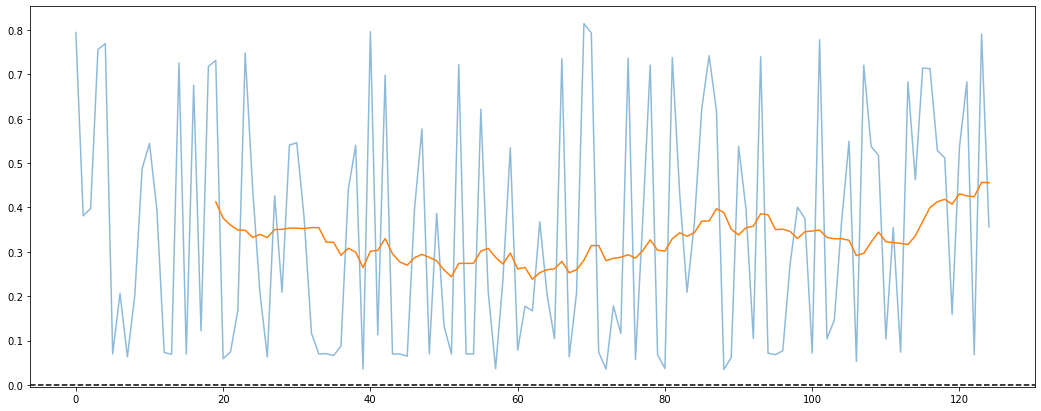

In [33]:
plt.figure(figsize=(18,7))
plt.plot(reward_list, alpha=0.5)
reward_list = pd.Series(reward_list)
plt.plot(reward_list.rolling(20).mean())
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

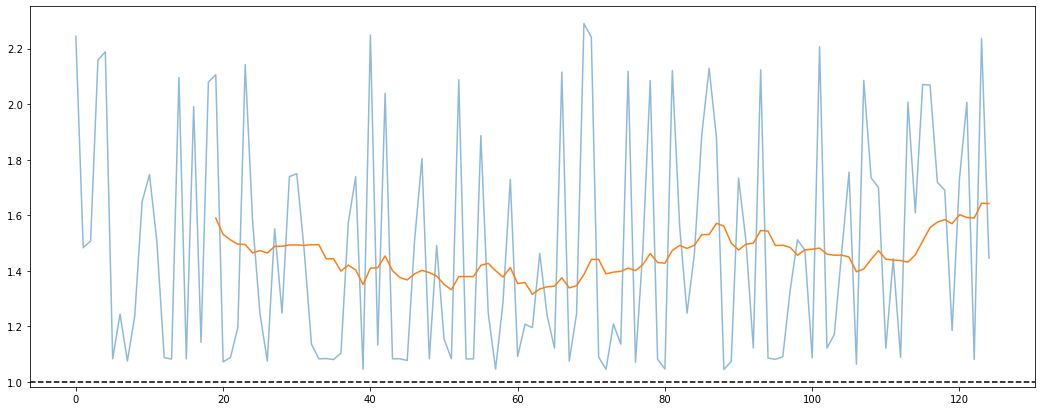

In [34]:
plt.figure(figsize=(18,7))
plt.plot(raw_return, alpha=0.5)
raw_return = pd.Series(raw_return)
plt.plot(raw_return.rolling(20).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

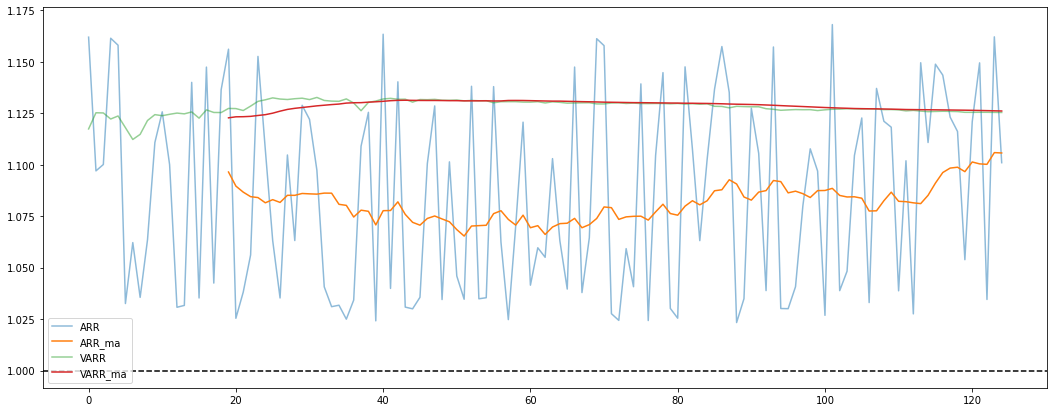

In [35]:
plt.figure(figsize=(18,7))
plt.plot(arr_list, alpha=0.5, label='ARR')
arr_list = pd.Series(arr_list)
plt.plot(arr_list.rolling(20).mean(), label='ARR_ma')
plt.plot(varr_list, alpha=0.5, label='VARR')
varr_list = pd.Series(varr_list)
plt.plot(varr_list.rolling(20).mean(), label='VARR_ma')
plt.axhline(y = 1, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.legend()
plt.show()

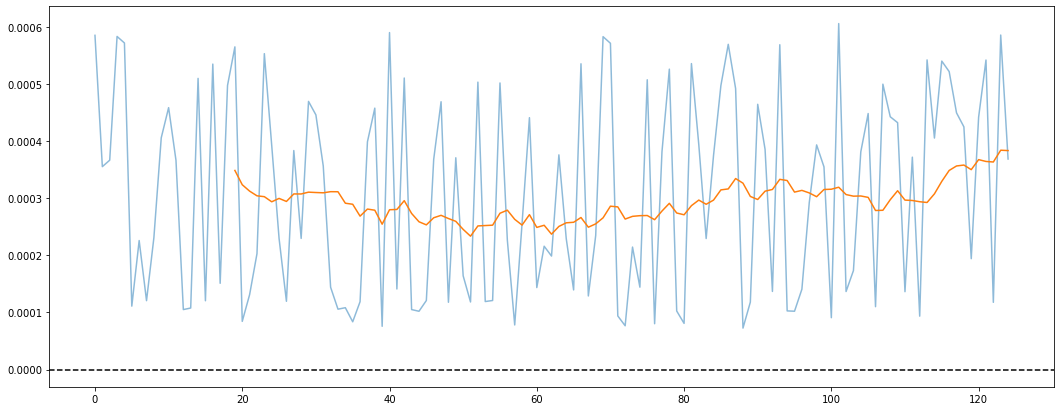

In [36]:
plt.figure(figsize=(18,7))
plt.plot(avg_rewards, alpha=0.5)
avg_rewards = pd.Series(avg_rewards)
plt.plot(avg_rewards.rolling(20).mean())
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

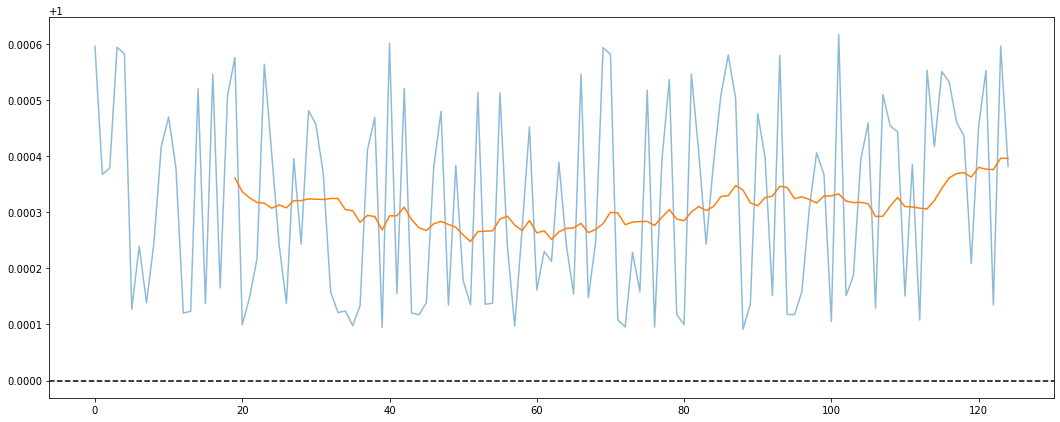

In [37]:
plt.figure(figsize=(18,7))
plt.plot(geomean_return, alpha=0.5)
geomean_return = pd.Series(geomean_return)
plt.plot(geomean_return.rolling(20).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

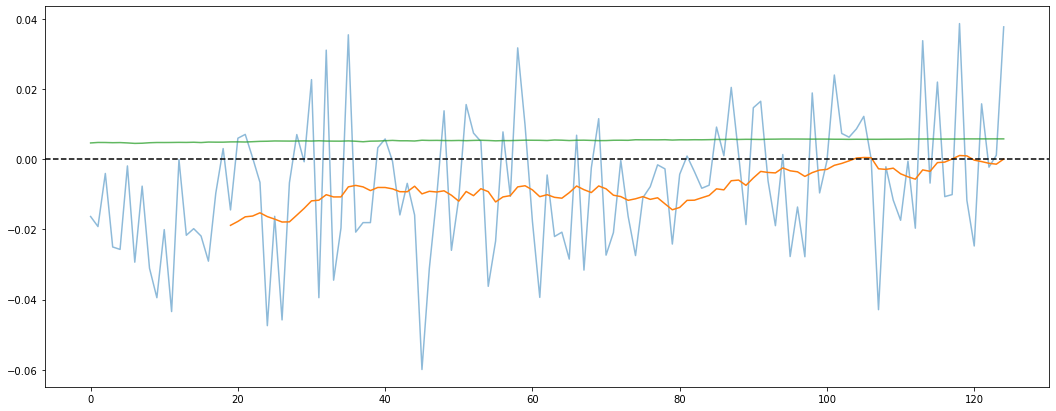

In [38]:
plt.figure(figsize=(18,7))
plt.plot(eps_aloss, alpha=0.5)
eps_aloss = pd.Series(eps_aloss)
plt.plot(eps_aloss.rolling(20).mean())
plt.plot(eps_valoss, alpha=0.75)
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.ylim(-0.75, 0.5)
plt.show()

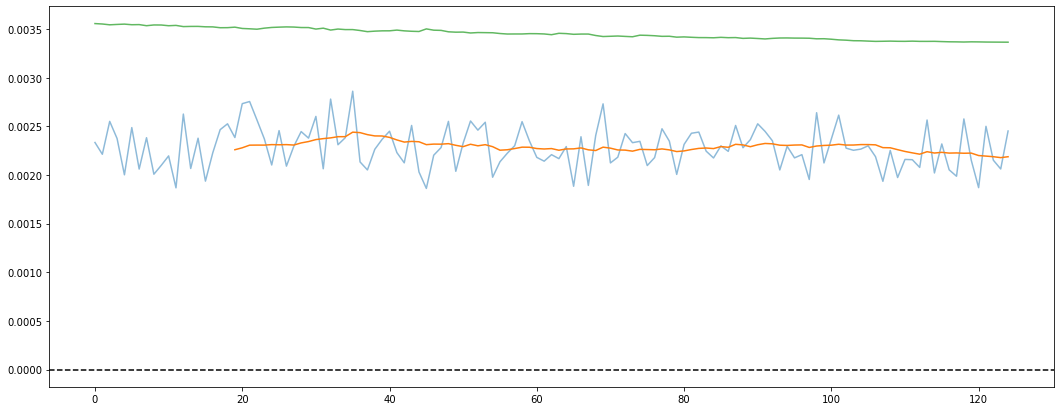

In [39]:
plt.figure(figsize=(18,7))
plt.plot(eps_closs, alpha=0.5)
eps_closs = pd.Series(eps_closs)
plt.plot(eps_closs.rolling(20).mean())
plt.plot(eps_vcloss, alpha=0.75)
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.ylim(-0.75, 0.5)
plt.show()

In [35]:
done = False
state = test_env.reset()
cumprod_return = 1
rewards = []
states = []
probs = []
dones = []
values = []
returns = []
num_steps = 0
    
while not done:
    action = act(state)[0]
    next_state, reward, done, info, day_return = test_env.step(action, DEFAULT_RISK_DISCOUNT)
    returns.append(day_return)
    dones.append(1-done)
    cumprod_return *= day_return
    rewards.append(reward)
    states.append(state)
    state = next_state
    num_steps += 1
    
cumsum = np.sum(rewards)
arr = (cumprod_return ** (1/(num_steps/252)))
geomean = (cumprod_return ** (1/num_steps))
mean = np.mean(rewards)

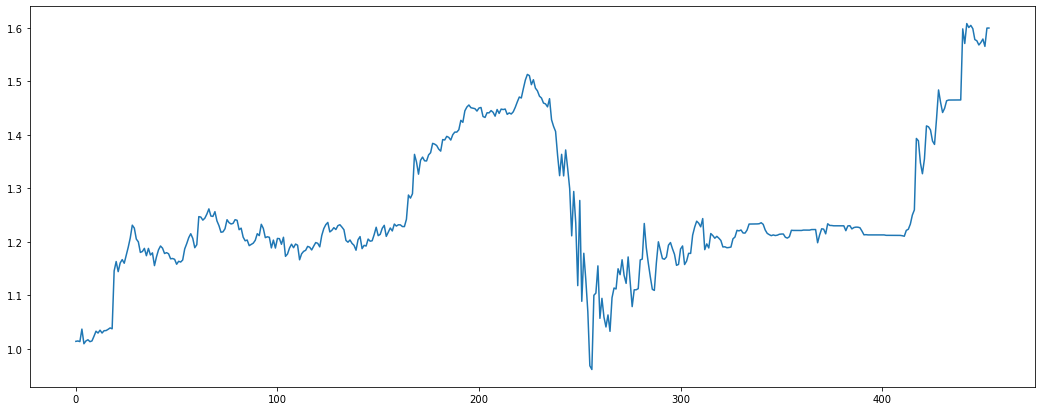

In [36]:
plt.figure(figsize=(18,7))
plt.plot(np.cumprod(returns))
plt.show()

In [39]:
return_series = pd.Series(returns)

In [40]:
with pd.HDFStore('test_results.h5') as store:
    store.put('SAM/test_set/returns', return_series)

In [40]:
actor.save_weights('SAM_EIIE_actor_625episodes.h5')
critic.save_weights('SAM_EIIE_critic_625episodes.h5')

In [41]:
actor.set_weights(best_actor_weights)
critic.set_weights(best_critic_weights)

In [42]:
actor.save_weights('SAM_actor_bestvalid_625episodes.h5')
critic.save_weights('SAM_critic_best_valid_625episodes.h5')

In [43]:
series = pd.Series(replay_buffer)

In [44]:
with pd.HDFStore('sam_training.h5') as store:
    store.put('SAM/EIIE/625episodes/neg_loss/replay_buffer', series)

C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '625episodes'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\isaac\AppData\Local\Temp\ipykernel_17368\4244756116.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put('SAM/EIIE/625episodes/neg_loss/replay_buffer', series)


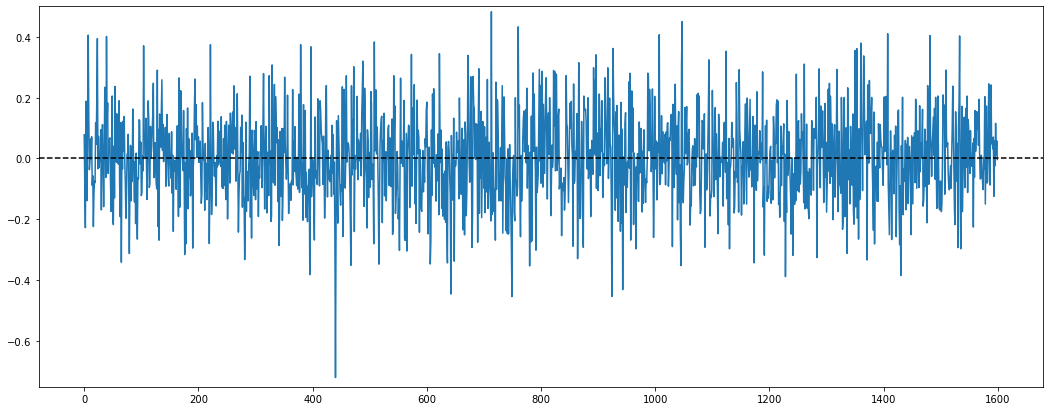

In [43]:
#1e-3
plt.figure(figsize=(18,7))
plt.plot(all_aloss, alpha=1)
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.ylim(-0.75, 0.5)
plt.show()

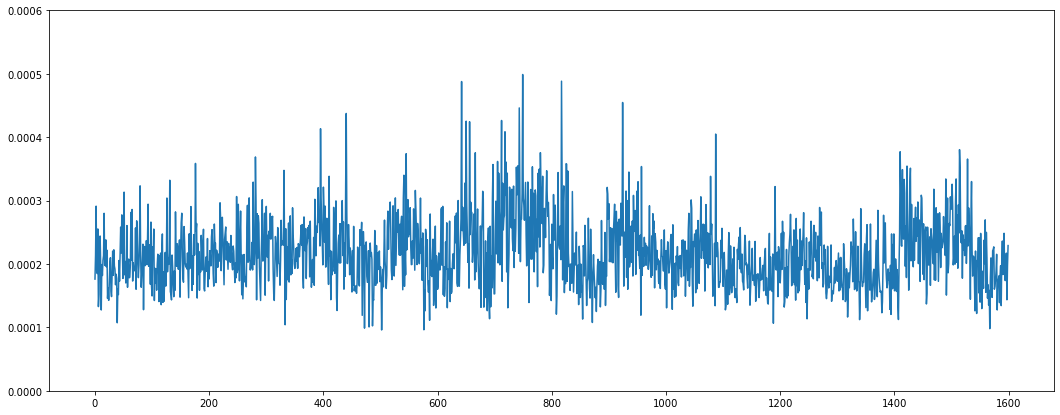

In [42]:
#1e-3
plt.figure(figsize=(18,7))
plt.plot(all_closs, alpha=1)
#plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.ylim(0, 6e-4)
plt.show()

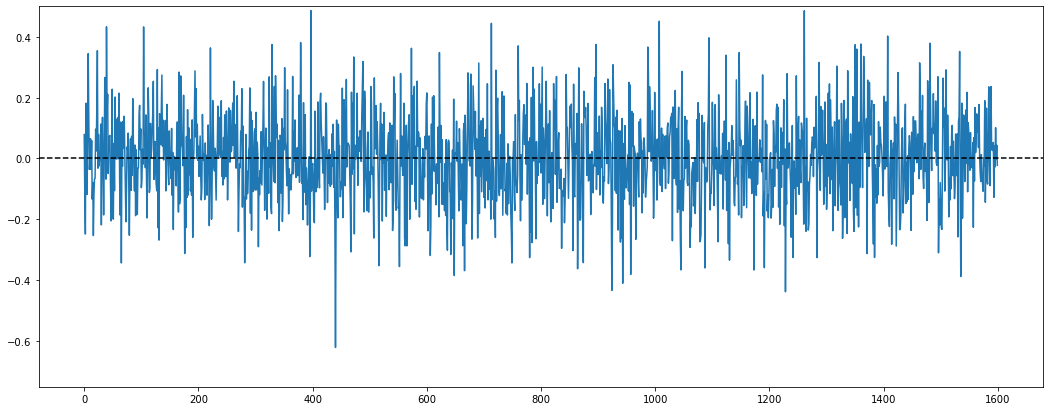

In [25]:
#1e-4
plt.figure(figsize=(18,7))
plt.plot(all_aloss, alpha=1)
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.ylim(-0.75, 0.5)
plt.show()

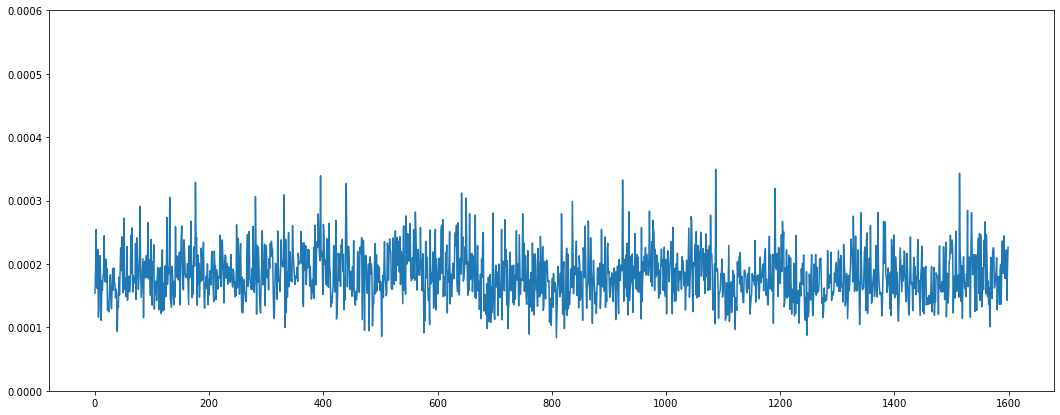

In [26]:
#1e-4
plt.figure(figsize=(18,7))
plt.plot(all_closs, alpha=1)
#plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.ylim(0, 6e-4)
plt.show()

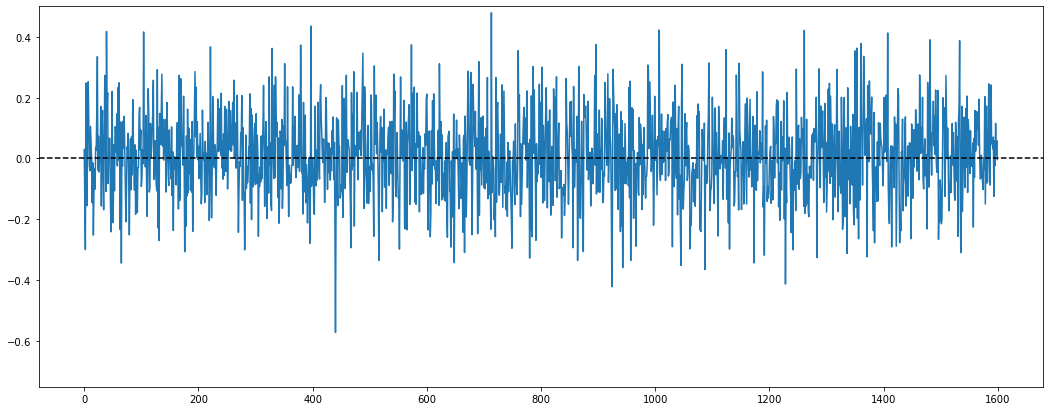

In [25]:
#1e-2
plt.figure(figsize=(18,7))
plt.plot(all_aloss, alpha=1)
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.ylim(-0.75, 0.5)
plt.show()

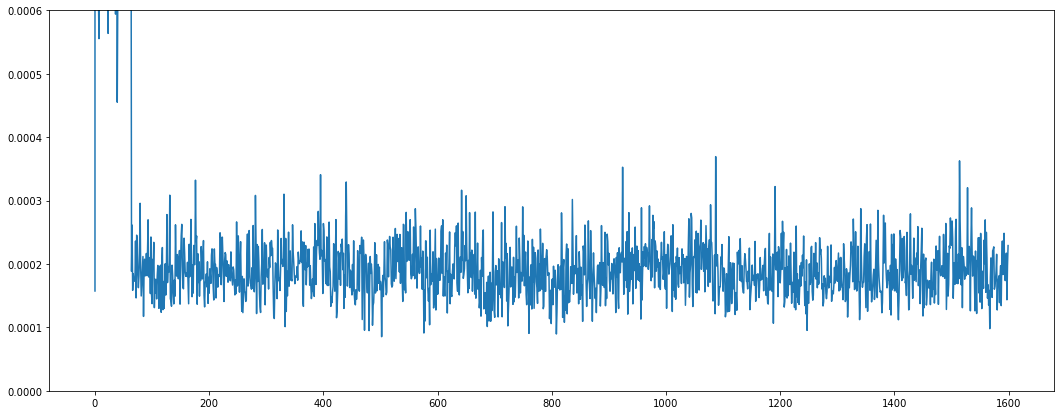

In [28]:
#1e-2
plt.figure(figsize=(18,7))
plt.plot(all_closs, alpha=1)
#plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.ylim(0, 6e-4)
plt.show()